#  Simple tool to analyze data from www.data.gouv.fr

**Note:** This is a Jupyter notebook which is also available as its executable export as a Python 3 script (therefore with automatically generated comments).

# Libraries

This is weird, apparently needed after transitionning to Ubuntu 21.04 Python 3.9.4, 
there must be another dir lib competing ... so order has become important??

In [1]:
import sys,os
addPath= [os.path.abspath("../venv/lib/python3.9/site-packages/"),
          os.path.abspath("../source")]
addPath.extend(sys.path)
sys.path = addPath

In [2]:
# Sys import
import sys, os, re
# Common imports
import math
import numpy             as NP
import numpy.random      as RAND
import scipy.stats       as STATS
from scipy import sparse
from scipy import linalg

# Some maths
from math import sqrt

import matplotlib        as MPL
import matplotlib.pyplot as PLT
# Add color
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as SNS
SNS.set(font_scale=1)

import mpl_toolkits
import mpl_toolkits.mplot3d.axes3d
from mpl_toolkits.mplot3d.axes3d import get_test_data

# Python programming
from itertools import cycle
from time import time
import datetime

# Using pandas
import pandas as PAN
import xlrd

In [3]:
#from sklearn.svm import SVC
#from sklearn import linear_model
from sklearn import cluster

In [4]:
import warnings
warnings.filterwarnings('ignore')
print("For now, reduce python warnings, I will look into this later")

For now, reduce python warnings, I will look into this later


### Import my own modules
The next cell attempts to give user some information if things improperly setup.
Intended to work both in Jupyter and when executing the Python file directly.

In [5]:
if not get_ipython() is None and os.path.abspath("../source/") not in sys.path:
    sys.path.append(os.path.abspath("../source/"))
try:
    from lib.utilities     import *
    from lib.figureHelpers import *
    from lib.DataMgrJSON   import *
    from lib.DataMgr       import *
    import lib.basicDataCTE as DCTE
    from lib import figureHelpers as FHelp
    import libApp.appFrance as appFrance
except Exception as err:
    print("Could not find library 'lib' with contents 'DataGouvFr' ")
    if get_ipython() is None:
        print("Check the PYTHONPATH environment variable which should point to 'source' wich contains 'lib'")
    else:
        print("You are supposed to be running in JupySessions, and '../source/lib' should exist")
    raise err

Loaded lib
For now, reduce python warnings, I will look into this later
Loaded libApp


## Check environment

It is expected that:
- your working directory is named `JupySessions`, 
- that it has subdirectories 
   - `images/*` where generated images may be stored to avoid overcrowding. 
- At the same level as your working dir there should be directories 
   - `../data` for storing input data and 
   - `../source` for python scripts.
   
My package library is in `../source/lib`, and users running under Python (not in Jupyter) should
set their PYTHONPATH to include "../source" ( *or whatever appropriate* ).

In [6]:
checkSetup(chap="Vac02")
ImgMgr = ImageMgr(chapdir="Vac02")

# Load Data

## Functions

## Load CSV and XLSX data from remote 
The `dataFileVMgr` will manage a cache of data files in `../dataVaccin`, the data will be downloaded
from www.data.gouv.fr using a request specified with tags and filtering file names and urls. The meta information is stored/cached  in `../dataVaccin/.data`
as the pickle of a json.

We check what is in the cache/data directory; for each file, we identify the latest version, 
and list this below to make sure. The file name will usually contain a time stamp; this has to do with 
the version management/identification technique used when downloading from www.data.gouv.fr.

For the files used in this notebook, the latest version is used/loaded irrespective of the
timestamp used in the notebook.

In [7]:
specOpts={ 'CacheValidity': 12*60*60, # normal caching period (seconds)
            'cacheFname': '.cache.vaccin.json',
            "dumpMetaFile" : "vaccin.meta.dump",
            "dumpMetaInfoFile" : "vaccin.metainfo.dump",
            'ApiInq'       : 'datasets',
            'InqParmsDir'  : {"tag":"covid"},
         }
rex = re.compile('.*vacsi-(v|tot)-(fra|reg|dep).*')
def uselFn(urqt):
    return rex.match(urqt.fname) or rex.match(urqt.url)

Fichiers avec le nombre de personnes ayant reçu au moins une dose ou complètement 
vaccinées, arrêté à la dernière date disponible :
  - vacsi-tot-fra-YYYY-MM-DD-HHhmm.csv (échelle nationale)
  - vacsi-tot-reg-YYYY-MM-DD-HHhmm.csv (échelle régionale)
  - vacsi-tot-dep-YYYY-MM-DD-HHhmm.csv (échelle départementale)


Fichiers avec le nombre quotidien de personnes ayant reçu au moins une dose, 
par vaccin, et par date d’injection :
  - vacsi-v-fra-YYYY-MM-DD-HHhmm.csv (échelle nationale)
  - vacsi-v-reg-YYYY-MM-DD-HHhmm.csv (échelle régionale)
  - vacsi-v-dep-YYYY-MM-DD-HHhmm.csv (échelle départementale)

Les vaccins sont codifiés de la façon suivante : 
- 0 : Tous vaccins\n'
- 1 : COMIRNATY Pfizer/BioNTech
- 2 : Moderna
- 3 : AstraZeneka
- 4 : Janssen

In [8]:
dataFileVMgr = manageAndCacheDataFilesFRAPI("../dataVaccin", maxDirSz= 24*(2**10)**2,
                                            **specOpts)
dataFileVMgr.getRemoteInfo()
dataFileVMgr.updatePrepare()
dataFileVMgr.updateSelect(displayCount=40 ,  URqtSelector = uselFn)

dataFileVMgr.printUpdtList('fname') 
dataFileVMgr.printUpdtList('url')

dataFileVMgr.cacheUpdate()

Need to reload cache from remote,  stale after 215h 34m 23s


In _mkRqtParms, self.options=
{   'ApiHeaders': {},
    'ApiInq': 'datasets',
    'ApiInqQuery': {},
    'CacheValidity': 43200,
    'HttpHDR': 'https://www.data.gouv.fr/api/1',
    'InqParmsDir': {'tag': 'covid'},
    'cacheFname': '.cache.vaccin.json',
    'dumpMetaFile': 'vaccin.meta.dump',
    'dumpMetaInfoFile': 'vaccin.metainfo.dump',
    'httpTimeOut': 20,
    'maxDirSz': 25165824,
    'maxImportSz': 5242880}
inq=datasets,	inqQuery={},	inqDict={'tag': 'covid'}
URL/request=https://www.data.gouv.fr/api/1/datasets/?tag=covid
	Status:200:ok
Size of collected data:88


Stored pickle in ../dataVaccin/.cache.vaccin.json


Per options['dumpMetaFile'], wrote data in file ../dataVaccin/vaccin.meta.dump
Per options['dumpMetaInfoFile'], wrote meta data in file ../dataVaccin/vaccin.metainfo.dump
UpdtList has len: 6
UpdtList starts with:
	<<class 'lib.DataMgr.UpdateRqt'>>:[[ reason = ReasonCde.IsNewer; dict={'fname': 'vacsi-v-fra-2021-10-26-19h08.csv', 'url': 'https://static.data.gouv.fr/resources/donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1/20211026-190859/vacsi-v-fra-2021-10-26-19h08.csv', 'latest': 'https://www.data.gouv.fr/fr/datasets/r/b273cf3b-e9de-437c-af55-eda5979e92fc', 'org': None, 'orgslug': 'NONE', 'checksum': {'type': 'sha1', 'value': '483ee484e8d41d5d4faa2d9722c3f5701a9e32c6'}, 'format': 'csv', 'modDate': '2021-10-26T19:09:00.030000', 'cachedDate': datetime.datetime(2021, 10, 26, 19, 8), 'filesize': 85315, 'genKey': 'vacsi-v-fra-!.csv'}]]
	<<class 'lib.DataMgr.UpdateRqt'>>:[[ reason = ReasonCde.IsNewer; dict={'fname': 'vacsi-v-reg-2021-10-26-19h08.csv', 'url': 'https://static.da

Selection: fname:
	vacsi-tot-dep-2021-10-26-19h09.csv
	vacsi-tot-fra-2021-10-26-19h09.csv
	vacsi-tot-reg-2021-10-26-19h09.csv
	vacsi-v-dep-2021-10-26-19h09.csv
	vacsi-v-fra-2021-10-26-19h08.csv
	vacsi-v-reg-2021-10-26-19h08.csv
Selection: url:
	https://static.data.gouv.fr/resources/donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1/20211026-190858/vacsi-v-reg-2021-10-26-19h08.csv
	https://static.data.gouv.fr/resources/donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1/20211026-190859/vacsi-v-fra-2021-10-26-19h08.csv
	https://static.data.gouv.fr/resources/donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1/20211026-190902/vacsi-v-dep-2021-10-26-19h09.csv
	https://static.data.gouv.fr/resources/donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1/20211026-190912/vacsi-tot-dep-2021-10-26-19h09.csv
	https://static.data.gouv.fr/resources/donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1/20211026-190913/vacsi-tot-reg-2021-10-26-19h09.c

In [9]:
last = lambda x: dataFileVMgr.getRecentVersion(x,default=True)

In [10]:
print("Most recent versions of files in data directory:")
for f in dataFileVMgr.listMostRecent() :
    print(f"\t{f}")

Most recent versions of files in data directory:
	vacsi-tot-dep-2021-10-26-19h09.csv
	vacsi-tot-fra-2021-10-26-19h09.csv
	vacsi-tot-reg-2021-10-26-19h09.csv
	vacsi-v-dep-2021-10-26-19h09.csv
	vacsi-v-fra-2021-10-26-19h08.csv
	vacsi-v-reg-2021-10-26-19h08.csv


This ensures we load the most recent version, so that it is not required to update the list 
below. The timestamps shown in the following sequence will be update by the call to `getRecentVersion`.

In [11]:
dailyVacDep = last("vacsi-v-dep-2021-08-20-19h09.csv")
dailyVacFr  = last("vacsi-v-fra-2021-08-20-19h09.csv")
dailyVacReg = last("vacsi-v-reg-2021-08-20-19h09.csv")

In [12]:
S1 = set (dataFileVMgr.listMostRecent())
S2 =set((dailyVacFr,dailyVacDep, dailyVacReg ))
missing = S1. difference(S2)
if len(missing) > 0:
    print (f"Not exploited comparing with most recent files in ../dataVaccin:")
for f in missing:
    print(f"\t{f}")
    
metaSexeCsv = "../data/metadonnees-sexe.csv"
metaRegionsCsv="../data/regions-france.csv"
metaTranchesAgeCsv="../data/code-tranches-dage.csv"

Not exploited comparing with most recent files in ../dataVaccin:
	vacsi-tot-reg-2021-10-26-19h09.csv
	vacsi-tot-fra-2021-10-26-19h09.csv
	vacsi-tot-dep-2021-10-26-19h09.csv


In [13]:
ad  = lambda x: "../dataVaccin/"+x
S1 = set (map(ad, dataFileVMgr.listMostRecent(nonTS=True)))
S2 =set(( metaRegionsCsv, metaTranchesAgeCsv, metaSexeCsv ))
missing = S1. difference(S2)
if len(missing) > 0:
    print (f"Missing comparing with non timestamped files in ../data:")
    print ("These may eventually be exploited in other notebooks (e.g. COVID-MoreData-FromGouv)")
    for f in missing:
        print(f"\t{f}")

Missing comparing with non timestamped files in ../data:
These may eventually be exploited in other notebooks (e.g. COVID-MoreData-FromGouv)
	../dataVaccin/.cache.json
	../dataVaccin/.cache.vaccin.json
	../dataVaccin/vaccin.metainfo.dump
	../dataVaccin/vaccin.meta.dump


Now load the stuff


In [14]:
ad  = lambda x: "../data/"+x
adv  = lambda x: "../dataVaccin/"+x
data_dailyRegion = read_csvPandas(adv(dailyVacReg), error_bad_lines=False,sep=";" )
data_dailyDep    = read_csvPandas(adv(dailyVacDep), error_bad_lines=False,sep=";")
data_dailyFrance = read_csvPandas(adv(dailyVacFr), error_bad_lines=False,sep=";")

meta_Sexe    = read_csvPandas(metaSexeCsv, clearNaN=True, error_bad_lines=False,sep=";",header=0)
meta_Regions = read_csvPandas(metaRegionsCsv, clearNaN=True, error_bad_lines=False,sep=",")
meta_Ages    = read_csvPandas(metaTranchesAgeCsv, clearNaN=True, error_bad_lines=False,sep=";")

## Figure out data characteristics

In [15]:
def showBasics(data,dataName):
    print(f"{dataName:24}\thas shape {data.shape}")

dataListDescr = ((data_dailyRegion, "data_dailyRegion"), 
                  (data_dailyDep,"data_dailyDep"), 
                  (data_dailyFrance, "data_dailyFrance"),
                  (meta_Sexe,"meta_Sexe"),
                  (meta_Regions,'meta_Regions'),
                  (meta_Ages,'meta_Ages'))
    
for (dat,name) in dataListDescr:
    showBasics(dat,name)


data_dailyRegion        	has shape (30300, 13)
data_dailyDep           	has shape (156045, 13)
data_dailyFrance        	has shape (1515, 13)
meta_Sexe               	has shape (3, 2)
meta_Regions            	has shape (18, 2)
meta_Ages               	has shape (6, 2)


### Focus on the recent period

In some displays, we may want to focus on the recent data, then the number of days is parametrized here.

In [16]:
nbLastDays=50

## Get some demographics data from INSEE
For the time being, these data are obtained / loaded from Insee web site using a manual process and are placed in a different directory, therefore a distinct FileManager is used, and loading this data is done here; for more details see the notebook `Pop-Data-FromGouv.ipy`

Using the base version which **does not try to update** the "../dataPop" directory

In [17]:
dataFileVMgrInsee = manageDataFileVersions("../dataPop") 
inseeDepXLS           ="../dataPop/InseeDep.xls"
inseeDep            = read_xlsxPandas(inseeDepXLS, sheet_name=1, header=7)
inseeReg            = read_xlsxPandas(inseeDepXLS, sheet_name=0, header=7)

Now we can display our demographics data (summarized)

In [18]:
display(inseeDep.iloc[:,4:].sum())
display(inseeReg.iloc[:,4:].sum())

Nombre d'arrondissements         332.0
Nombre de cantons               2041.0
Nombre de communes             34953.0
Population municipale       66524339.0
Population totale           67761092.0
dtype: float64

Nombre de communes          34953
Population municipale    66524339
Population totale        67761092
dtype: int64

## Let's do some graphics!

### Merge Vaccination and demographics data
See the `Pop-Data-FromGouv.ipynb` notebook for more details on the demographics data obtained from
INSEE (https://www.insee.fr/fr/accueil). 

## Whole France

In [19]:
vacFrf = data_dailyFrance.copy()
vac0Frf = vacFrf.loc[vacFrf.loc[:,'vaccin']==0,:].set_index("jour")

Here, it would be a good idea to apply a low pass filter!!

## Split according to vaccine type
see in a second step, not sure that I am really interested in vaccine type for now!

In [20]:
vaccNames= { 0 : 'All vaccines',
            1 : 'Pfizer/BioNTech',
            2 : 'Moderna',
            3 : 'Astra Zeneka',
            4 : 'Janssen'}

In [21]:
vac1Frf = vacFrf.set_index("jour")

In [22]:
vac1GrFrf=vac1Frf.groupby('vaccin')

In [23]:
subnodeSpec=(lambda i,j:{"nrows":i,"ncols":j})(*subPlotShape(len(vac1GrFrf),maxCol=2))

## Look at the distribution accross areas ('departements')

### Basics

Prepare the data for a database style join/merge, documented on https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html.
First we need to establish "dep" as an index in our data: 

In [24]:
vacDepf = data_dailyDep.copy()
vacDepf.loc[:,"dep"] = vacDepf.loc[:,"dep"].apply(str) 
vacDepfV=vacDepf.set_index("vaccin")

*At this date (26/9/21) the "dep" column contains a mix of integer and str encodings, which causes failure down the road (look a merge...); so we corrected this in second
instruction above.*

Here we discover that for vaccine code 0 (all vaccines) the cumulative columns have not been filled!! As somebody said, *real data is often cause for 
surprises*!! I correct this situation here, not *checking whether progessively summing daily contributions will give the same result*. 

In [25]:
for col in ('n_cum_dose1', 'n_cum_dose2'):
    vacDepfV.loc[0, col] = vacDepfV.loc[1, col].values
    for i in range(2,5):
        vacDepfV.loc[0, col] += vacDepfV.loc[i, col].values

In [26]:
vacDepf = vacDepfV.reset_index()

Then we extract the demographic information and set index "dep" 

In [27]:
depStats = inseeDep.iloc[:,[2,3,7,8]].copy()
cols = depStats.columns.values
cols[0]="dep"
depStats.columns = cols
depStats.set_index("dep");

Now we perform the merge, and group by date and 'départements': 

In [28]:
vacMerged = PAN.merge(vacDepf,depStats, on="dep" ) 
vacGrMerged=vacMerged.groupby(["dep","jour","vaccin"]).sum()

In [29]:
deps=depStats.iloc[:,0]
deps1=set(vacGrMerged.index.get_level_values(0))
sdiff = deps1-set(deps)
sdiffR = set(deps)-deps1

if len(sdiff) > 0:
    raise RuntimeError (f"Missing departements in depStats (pop stats):{sdiff}")

if len(sdiffR) > 0:
    raise RuntimeError(f"Non represented departements in vacGrMerged:{sorted(sdiffR)}")

In [30]:
colLabs = ("n_dose1", "n_dose2", "n_cum_dose1", "n_cum_dose2")
for lab in colLabs:
    vacGrMerged[lab+"_rate"] = vacGrMerged[lab]/vacGrMerged["Population totale"]*100

In [31]:
print(f"vacDepf.shape ={vacDepf.shape}")
print(f"depStats.shape={depStats.shape}")
print(f"vacMerged.shape={vacMerged.shape}")
print(f"vacGrMerged.shape={vacGrMerged.shape}")
print(f"data_dailyDep.shape={data_dailyDep.shape}")

print(f"vacMerged.columns:{vacMerged.columns}")
print(f"vacGrMerged.columns:{vacGrMerged.columns}")

vacDepf.shape =(156045, 13)
depStats.shape=(100, 4)
vacMerged.shape=(148773, 16)
vacGrMerged.shape=(148773, 16)
data_dailyDep.shape=(156045, 13)
vacMerged.columns:Index(['vaccin', 'dep', 'jour', 'n_dose1', 'n_dose2', 'n_dose3', 'n_dose4',
       'n_rappel', 'n_cum_dose1', 'n_cum_dose2', 'n_cum_dose3', 'n_cum_dose4',
       'n_cum_rappel', 'Nom du département', 'Population municipale',
       'Population totale'],
      dtype='object')
vacGrMerged.columns:Index(['n_dose1', 'n_dose2', 'n_dose3', 'n_dose4', 'n_rappel', 'n_cum_dose1',
       'n_cum_dose2', 'n_cum_dose3', 'n_cum_dose4', 'n_cum_rappel',
       'Population municipale', 'Population totale', 'n_dose1_rate',
       'n_dose2_rate', 'n_cum_dose1_rate', 'n_cum_dose2_rate'],
      dtype='object')


For now, look at daily statistics normalized by concerned population (unit= event per million people)

Select `vaccin == 0` (all vaccine types), iterate on `dep` (if this is doable
on a multi-index, note that `vacGrMerged` is a `pandas.core.frame.DataFrame`.)
- https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe is quite comprehensive on slicing multi-indices
- we select `vaccin == 0` with `loc[slice(None),slice(None),0]` selector

In [32]:
vacAllPanda=vacGrMerged.loc[slice(None),slice(None),0]

We take this opportunity to check that all departements are represented

In [33]:
deps=depStats.iloc[:,0]
deps1=set(vacAllPanda.index.get_level_values(0))
sdiff = deps1-set(deps)
if len(sdiff) > 0:
    raise RuntimeError (f"Missing departements in depStats (pop stats):{sdiff}")


In [34]:
vacGrMerged.loc[slice(None),slice(None),0].loc[:,('n_cum_dose1','n_cum_dose2') ].describe()

,n_cum_dose1,n_cum_dose2
count,2.757300e+04,2.757300e+04
mean,2.588694e+05,1.787344e+05
std,3.171681e+05,2.511466e+05
min,0.000000e+00,0.000000e+00
25%,3.737700e+04,1.572000e+04
50%,1.441310e+05,7.660700e+04
75%,3.624120e+05,2.390140e+05
max,2.005725e+06,1.687582e+06


We also make a dict to get information about a departement from its id as a string representing a number. There is an **issue** here since *code 976 (Mayotte) is missing,
as well as code 975 (St Pierre et Miquelon)*. When this **blows up...** I will have to do something about it!!

In [35]:
depDict = {depStats.iloc[i,0]:i for i in range(depStats.shape[0])}

This is how this works and this solves the mystery about 97X numbers!

In [36]:
depStats.iloc[list(depDict[f"{i}"] for i in range(971,975)) ,:]

,dep,Nom du département,Population municipale,Population totale
96,971,Guadeloupe,390253,396153
97,972,Martinique,372594,377711
98,973,Guyane,268700,271124
99,974,La Réunion,853659,863063


What corresponds to departement with number '976' (Mayotte), missing here, 
remains to be seen... But at this point this is non blocking. Of course we used the trick of converting to a set
to get the unique values used in the 'dep' multi-index level.

And the graph can be readily generated:

For vaccine coverage, we determine it on last day in table. 
This implementation requires all departements to have entries for the last day!!

First we prepare by getting access to the vaccination rates:

In [37]:
lastDay=max(vacAllPanda.index.levels[1])
vaccAllLast=vacAllPanda.loc[(slice(None),lastDay),:]
vRates = vaccAllLast.loc[:, ('n_cum_dose1_rate','n_cum_dose2_rate')]

### Compare vaccination achievements accross departements

<HTML><COLOR:'RED'></HTML>This figure need to be redone <HTML></COLOR></HTML>
    as a point cloud, with no xlabels, improved xlabels,
or as an X-Y cloud, possibly showing the label at each point (too cluttered?), also look at the graphs we want to make... (rates/population...)

### Mix vaccine and COVID Data on departemental level

##### Load and prepare COVID Data
This has been copied from 'COVID-Data-FromGouv(-Later)', postfix 'D' is used to name
objects, since they will be used with previously loaded data.

In [38]:
tagset1D = ({"tag":"covid"}, {"tag":"covid19"})
specOptsD={ 'cacheFname': '.cache.tag-covid.json',
           "dumpMetaFile" : "data-gouv-fr.meta.dump",
           "dumpMetaInfoFile" : "data-gouv-fr.metainfo.dump",
           'ApiInq'       : 'datasets',
           'ApiInqQuery'  : tagset1D,
           'InqParmsDir'  : {},
          }
rexD = re.compile('(.*sursaud|^donnees-hospitalieres).*')
def uselFnD(urqt):
                return rexD.match(urqt.fname) or rexD.match(urqt.url)

In [39]:
dataFileVMgrD = manageAndCacheDataFilesFRAPI("../data", maxDirSz= 170*(2**10)**2,
                                            **specOptsD)
dataFileVMgrD.getRemoteInfo()
dataFileVMgrD.updatePrepare()
dataFileVMgrD.updateSelect(displayCount=40 ,  URqtSelector = uselFnD)
dataFileVMgrD.cacheUpdate()

In cacheSpaceRecovery, looking for 7216553.0 bytes
Printing genDir collected for preparing Cache Recovery

Gen.File:	'sp-pos-heb-dep-!.csv'
	To be scavenged:
		2.232Mb	'../data/sp-pos-heb-dep-2021-10-04-19h05.csv'
	Kept
		2.326Mb	'../data/sp-pos-heb-dep-2021-10-26-19h08.csv'

Gen.File:	'sp-pos-heb-fra-!.csv'
	To be scavenged:
		0.049Mb	'../data/sp-pos-heb-fra-2021-10-04-19h05.csv'
	Kept
		0.051Mb	'../data/sp-pos-heb-fra-2021-10-26-19h08.csv'

Gen.File:	'sp-pos-heb-reg-!.csv'
	To be scavenged:
		0.715Mb	'../data/sp-pos-heb-reg-2021-10-04-19h05.csv'
	Kept
		0.745Mb	'../data/sp-pos-heb-reg-2021-10-26-19h08.csv'

Gen.File:	'sp-pos-quot-fra-!.csv'
	To be scavenged:
		0.330Mb	'../data/sp-pos-quot-fra-2021-10-04-19h05.csv'
	Kept
		0.345Mb	'../data/sp-pos-quot-fra-2021-10-26-19h08.csv'

Gen.File:	'sp-pos-quot-reg-!.csv'
	To be scavenged:
		4.840Mb	'../data/sp-pos-quot-reg-2021-10-04-19h05.csv'
	Kept
		5.052Mb	'../data/sp-pos-quot-reg-2021-10-26-19h08.csv'

Gen.File:	'sursaud-corona-quot-dep-!.

Per options['dumpMetaFile'], wrote data in file ../data/data-gouv-fr.meta.dump
Per options['dumpMetaInfoFile'], wrote meta data in file ../data/data-gouv-fr.metainfo.dump
UpdtList has len: 10
UpdtList starts with:
	<<class 'lib.DataMgr.UpdateRqt'>>:[[ reason = ReasonCde.IsNewer; dict={'fname': 'donnees-hospitalieres-classe-age-hebdo-covid19-2021-10-21-19h06.csv', 'url': 'https://static.data.gouv.fr/resources/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/20211021-190614/donnees-hospitalieres-classe-age-hebdo-covid19-2021-10-21-19h06.csv', 'latest': 'https://www.data.gouv.fr/fr/datasets/r/dc7663c7-5da9-4765-a98b-ba4bc9de9079', 'org': None, 'orgslug': 'NONE', 'checksum': {'type': 'sha1', 'value': 'a433b6fd33fd21ac3b83d544aea888cfbd6af46a'}, 'format': 'csv', 'modDate': '2021-10-21T19:06:14.495000', 'cachedDate': datetime.datetime(2021, 10, 21, 19, 6), 'filesize': 399796, 'genKey': 'donnees-hospitalieres-classe-age-hebdo-covid19-!.csv'}]]
	<<class 'lib.DataMgr.UpdateRqt'>>:[[ reas

In [40]:
lastD = lambda x: dataFileVMgrD.getRecentVersion(x,default=True)

In [41]:
print("Most recent versions of files in data directory:")
for f in dataFileVMgrD.listMostRecent() :
    print(f"\t{f}")

Most recent versions of files in data directory:
	covid-hospit-incid-reg-2021-10-26-19h05.csv
	donnees-hospitalieres-classe-age-covid19-2021-10-26-19h05.csv
	donnees-hospitalieres-classe-age-hebdo-covid19-2021-10-21-19h06.csv
	donnees-hospitalieres-covid19-2021-10-26-19h05.csv
	donnees-hospitalieres-etablissements-covid19-2021-10-26-19h05.csv
	donnees-hospitalieres-nouveaux-covid19-2021-10-26-19h05.csv
	sp-pos-heb-2020-07-01-19h15.xlsx
	sp-pos-heb-dep-2021-10-26-19h08.csv
	sp-pos-heb-fra-2021-10-26-19h08.csv
	sp-pos-heb-reg-2021-10-26-19h08.csv
	sp-pos-quot-2020-07-03-19h15.xlsx
	sp-pos-quot-dep-2021-10-26-19h08.csv
	sp-pos-quot-fra-2021-10-26-19h08.csv
	sp-pos-quot-reg-2021-10-26-19h08.csv
	sursaud-corona-hebdo-2020-07-15-19h15.csv
	sursaud-corona-quot-dep-2021-10-26-19h05.csv
	sursaud-corona-quot-reg-2021-10-26-19h05.csv
	sursaud-covid19-hebdomadaire-2020-06-24-19h00.csv
	sursaud-covid19-quotidien-2020-07-03-19h00-france.csv
	sursaud-covid19-quotidien-2020-07-03-19h00.xlsx


In [42]:
dailyDepCsv    = lastD("sursaud-corona-quot-dep-2021-04-08-21h20.csv")
hospNouveauCsv = lastD("donnees-hospitalieres-nouveaux-covid19-2020-04-11-19h00.csv")
adD  = lambda x: "../data/"+x
data_dailyDep    = read_csvPandas(adD(dailyDepCsv), error_bad_lines=False,sep=";")
data_hospNouveau = read_csvPandas(adD(hospNouveauCsv), error_bad_lines=False,sep=";")

We use `nbDaysFilter` for averaging daily data when such filtering is needed.
There is a parameter `nbLastDays` above for representing recent data; for avoiding issues with week ends, make this a multiple of 7.

In [43]:
nbDaysFilter=7

In [44]:
hndDf = data_hospNouveau.set_index( ["dep","jour"]).copy()

print(f"hnDf:\n\tcolumn names:{hndDf.columns.values}"
      +f"\n\tmulti-index names:{hndDf.index.names}")

hnDf:
	column names:['incid_hosp' 'incid_rea' 'incid_dc' 'incid_rad']
	multi-index names:['dep', 'jour']


Check that in this table, all departements use same set of dates, and store it in `hndDateList`:

In [45]:
hndDfG=hndDf.groupby(['dep'])
hndDateList=None
for dep in hndDfG:
    gg=hndDfG.get_group(dep[0]).copy()
    if hndDateList is None:
        hndDateList=gg.reset_index('jour')['jour'].values
    else:
        assert  (hndDateList ==  gg.reset_index('jour')['jour'].values).all()

Now, we run the same process for the `data_dailyDep` frame! 
*But there is an issue here!*

In [46]:
dDf=data_dailyDep
dDfTypes=set( dDf.loc[:,'dep'].apply(type))
print(f"column 'dep' contains data with types {dDfTypes}")
for t in dDfTypes:
    cc = dDf.loc[:,'dep'].apply(lambda x: isinstance(x,t))
    print(f"Count of {t} :  {cc.sum()}")
set(dDf.loc[:,'dep'].values)
def cvFun(x):
    if isinstance(x,int):
        return f"{x:02d}"
    return x
depColAsStr=dDf.loc[:,'dep'].apply(cvFun)

column 'dep' contains data with types {<class 'int'>, <class 'str'>}
Count of <class 'int'> :  336892
Count of <class 'str'> :  32768


In [47]:
for x in set(depColAsStr.values):
    if x not in depDict:
        print(f"There is a departement code not in depDict:{x}")

There is a departement code not in depDict:976


We correct the table nevertheless, and hope for the best(?)

In [48]:
dDf.loc[:,'dep'] = depColAsStr

In [49]:
dDf=data_dailyDep.set_index(["dep","sursaud_cl_age_corona",'date_de_passage'] ).copy()

print(f"dDf:\n\tcolumn names:{dDf.columns.values}"
      +f"\n\tmulti-index names:{dDf.index.names}")

dDf:
	column names:['nbre_pass_corona' 'nbre_pass_tot' 'nbre_hospit_corona'
 'nbre_pass_corona_h' 'nbre_pass_corona_f' 'nbre_pass_tot_h'
 'nbre_pass_tot_f' 'nbre_hospit_corona_h' 'nbre_hospit_corona_f'
 'nbre_acte_corona' 'nbre_acte_tot' 'nbre_acte_corona_h'
 'nbre_acte_corona_f' 'nbre_acte_tot_h' 'nbre_acte_tot_f']
	multi-index names:['dep', 'sursaud_cl_age_corona', 'date_de_passage']


This is a check that all departement's data are relative the same dates! Seems
weird, but this has permitted to diagnose that there was a mix of integer and string
data in the "dep" column (string needed because of Corsica 2A and 2B codes!!!)

In [50]:
dDfG=dDf.groupby(['dep', "sursaud_cl_age_corona"])
dDateList=None
for dep in dDfG:
    gg=dDfG.get_group(dep[0]).copy().reset_index('date_de_passage')['date_de_passage'].values
    if dDateList is None:
        dDateList=gg
    else:
        if len(gg)!= len (dDateList):
            print(f"Different number of dates for dep={dep[0]}; was:{len(dDateList)}"+
                  f" This one: {len(gg)}")


#### Extract last days values
Last days values are averaged over a period of time, as parametrized
by `nbDaysFilter`, and this is represented in `hndLDays`. 
For now, we are using the data from 
`donnees-hospitalieres-nouveaux-covid19.*` (`hndDf`); this is consistent with
per departement graphs in `COVID-Data-FromGouv-Later`.

In [51]:
display(hndDf.describe())
display(dDf.describe())

,incid_hosp,incid_rea,incid_dc,incid_rad
count,59874.000000,59874.000000,59874.000000,59874.000000
mean,9.158282,1.680295,1.534105,7.307997
std,18.516946,3.977909,3.354967,13.635658
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000,2.000000
75%,10.000000,2.000000,2.000000,8.000000
max,404.000000,96.000000,76.000000,222.000000


,nbre_pass_corona,nbre_pass_tot,nbre_hospit_corona,nbre_pass_corona_h,nbre_pass_corona_f,nbre_pass_tot_h,nbre_pass_tot_f,nbre_hospit_corona_h,nbre_hospit_corona_f,nbre_acte_corona,nbre_acte_tot,nbre_acte_corona_h,nbre_acte_corona_f,nbre_acte_tot_h,nbre_acte_tot_f
count,365586.000000,365586.000000,365586.000000,60991.000000,60991.000000,60991.000000,60991.000000,60991.000000,60991.000000,167504.000000,167504.000000,28051.000000,28051.000000,28051.000000,28051.000000
mean,3.101765,130.240876,1.474189,4.603253,4.691987,202.959223,187.339476,2.430457,1.987572,2.995033,64.830846,3.915475,5.033368,82.921571,111.014188
std,9.236028,190.959046,4.163477,9.299329,9.657490,167.794890,154.078343,4.784746,3.779569,7.090684,99.862772,5.894904,7.594831,72.755689,95.277289
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,32.000000,0.000000,0.000000,0.000000,88.000000,82.000000,0.000000,0.000000,0.000000,12.000000,1.000000,1.000000,39.000000,54.000000
50%,1.000000,65.000000,0.000000,2.000000,2.000000,149.000000,137.000000,1.000000,1.000000,1.000000,30.000000,2.000000,3.000000,58.000000,79.000000
75%,3.000000,141.000000,1.000000,5.000000,5.000000,263.000000,242.000000,3.000000,2.000000,3.000000,76.000000,5.000000,6.000000,98.000000,132.000000
max,635.000000,2560.000000,203.000000,320.000000,315.000000,1392.000000,1240.000000,130.000000,76.000000,259.000000,1444.000000,121.000000,144.000000,621.000000,824.000000


In [52]:
hndDfG=hndDf.groupby('dep')
dataAsDict={}
for (dep,depTb) in hndDfG:
    #print(f"dep={dep} {depTb.shape}")
    ll = depTb.iloc[-nbDaysFilter:, :]
    llm = ll.mean()
    dataAsDict[dep] = llm
    #print(f"{llm}")
hndLDays=PAN.DataFrame.from_dict(dataAsDict, orient='index')

#### Prepare and Merge data 

Here we want to merge with other data:
- need population count in the various territories
- need vaccination data

First, we embark on getting vaccination data averaged over the last `nbDaysFilter`
days; the dates are listed in `lastDays`.

A quite comprehensive treatment of selection with multi-indices appears in
https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe . All considered, I decide to use selection with a binary mask built over the index:

In [59]:
v=vacDepf.set_index(["vaccin", "dep", "jour"]).loc[0, slice(None),slice(None)]
lastDays=v.loc["1"].index.values[-nbDaysFilter:]
print(f"list of lastDays: {lastDays}")
assert len(lastDays) == nbDaysFilter

list of lastDays: ['2021-10-19' '2021-10-20' '2021-10-21' '2021-10-22' '2021-10-23'
 '2021-10-24' '2021-10-25']


In [60]:
vSelLast=v[v.index.get_level_values('jour').map(lambda x: x in lastDays)]
print(f"vSelLast has\tshape={vSelLast.shape},"
      +f"\n\t\tnb departement chunks:{vSelLast.shape[0] / nbDaysFilter}")

vSelLast has	shape=(721, 10),
		nb departement chunks:103.0


For each département:
- we compute averages over `nbDaysFilter` last days for the vaccine delivery, which needs low pass filtering to avoid day to day variation and systematic variation on week ends
- use vaccine cumulative data from the last day, since it is already a summation.

In [61]:
vSelLastG=vSelLast.groupby('dep')
dataAsDict={}
for (dep,depTb) in vSelLastG:
    ll = depTb.iloc[-nbDaysFilter:, :]
    llm = ll.mean()
    for c in ("n_cum_dose1","n_cum_dose2"):
        llm[c] = depTb.iloc[-1:, :].loc[:,c]
    dataAsDict[dep] = llm
vacDepAvg=PAN.DataFrame.from_dict(dataAsDict, orient='index')

In [62]:
vacDepAvg

,n_dose1,n_dose2,n_dose3,n_dose4,n_rappel,n_cum_dose1,n_cum_dose2,n_cum_dose3,n_cum_dose4,n_cum_rappel
1,181.000000,382.571429,486.571429,0.857143,539.000000,416795.0,348913.0,18267.142857,14.428571,18433.857143
10,102.142857,183.571429,399.571429,0.285714,406.428571,235685.0,209636.0,12363.714286,15.571429,12129.428571
11,141.142857,217.428571,462.571429,0.142857,476.714286,271144.0,245749.0,15554.714286,7.857143,15224.285714
12,75.571429,103.428571,298.000000,0.000000,313.428571,217019.0,197422.0,13260.142857,1.000000,13024.428571
13,864.000000,1248.571429,2279.000000,2.714286,2379.428571,1443277.0,1219920.0,70812.714286,67.714286,69404.142857
...,...,...,...,...,...,...,...,...,...,...
973,138.571429,139.857143,41.428571,0.000000,37.000000,83338.0,63569.0,1325.428571,0.000000,887.428571
974,774.142857,869.571429,247.571429,0.000000,274.857143,507989.0,450306.0,9644.571429,7.000000,8071.571429
976,531.571429,770.571429,8.142857,0.000000,8.000000,144950.0,99115.0,316.428571,0.000000,227.428571
977,2.428571,6.857143,3.142857,0.000000,3.000000,6807.0,5865.0,148.857143,0.000000,131.000000


Codes **missing** in `depDict` (it was loaded from Data originating at Insee??!!, **Check**)
- 975 : St Pierre et Miquelon
- 976 : Mayotte
- 977 : St Barthelemy
- 978 : St Martin

Now, we embark on merging..
- `vacDepAvg` : vaccination average over last days
- `hndLDays`  : incidence average over last days
- `depStats`  : population statistics (with some missing entries!!)



In [63]:
depStatIdx=depStats.copy().set_index('dep')
depStatIdx

,Nom du département,Population municipale,Population totale
dep,,,
01,Ain,643350,659180
02,Aisne,534490,546527
03,Allier,337988,347035
04,Alpes-de-Haute-Provence,163915,168381
05,Hautes-Alpes,141284,145883
...,...,...,...
95,Val-d'Oise,1228618,1239262
971,Guadeloupe,390253,396153
972,Martinique,372594,377711


Now we need to use a 3 way merge of indexed data in `depStatIdx`, `hndLDays` and `vacDepAvg`

In [64]:
def substFirstColname(tble,name):
    l = [name]
    l.extend(tble.columns.values[1:])
    tble.columns=l

In [65]:
t1=depStatIdx.reset_index()
t2=hndLDays.reset_index()
t3=vacDepAvg.reset_index()
substFirstColname(t2,"dep")
substFirstColname(t3,"dep")

In [66]:
vacM1 = PAN.merge(t1, t2, on="dep" ) 
vacDepMerged=PAN.merge(vacM1, t3, on="dep" ) 
vacGrMerged=vacMerged.groupby(["dep","jour","vaccin"]).sum()

Depending on the data we compute occurrences per million population or as percentage of population.

In [67]:
colLabs = ( 'incid_hosp', 'incid_rea', 'incid_dc', 'incid_rad',
            'n_dose1', 'n_dose2', 
           'n_cum_dose1', 'n_cum_dose2')
for lab in colLabs[:6]:
    vacDepMerged[lab+"_perM"] = vacDepMerged[lab]/vacDepMerged["Population totale"]*1.0e6
for lab in colLabs[6:]:
    vacDepMerged[lab+"_perC"] = vacDepMerged[lab]/vacDepMerged["Population totale"]*100    


In [68]:
print(vacDepMerged.describe().loc["mean",:].iloc[2:])

incid_hosp               2.348509
incid_rea                0.623234
incid_dc                 0.284144
incid_rad                2.106750
n_dose1                244.361068
n_dose2                405.940345
n_dose3                709.249608
n_dose4                  1.083203
n_rappel               756.048666
n_cum_dose1         528022.439560
n_cum_dose2         463009.648352
n_cum_dose3          24511.282575
n_cum_dose4             33.558870
n_cum_rappel         24644.503925
incid_hosp_perM          3.500345
incid_rea_perM           0.877663
incid_dc_perM            0.401815
incid_rad_perM           3.067214
n_dose1_perM           332.739360
n_dose2_perM           554.224783
n_cum_dose1_perC        74.267786
n_cum_dose2_perC        65.893238
Name: mean, dtype: float64


In [69]:
vd=vacDepMerged.describe().loc[['mean','std']]
for c in vd.columns[2:]:
    print(f"{c:20s} mean={vd.loc['mean',c]:7.2e}\tstd={vd.loc['std',c]:7.2e}")

incid_hosp           mean=2.35e+00	std=2.63e+00
incid_rea            mean=6.23e-01	std=7.37e-01
incid_dc             mean=2.84e-01	std=4.11e-01
incid_rad            mean=2.11e+00	std=2.72e+00
n_dose1              mean=2.44e+02	std=2.10e+02
n_dose2              mean=4.06e+02	std=3.52e+02
n_dose3              mean=7.09e+02	std=5.32e+02
n_dose4              mean=1.08e+00	std=1.29e+00
n_rappel             mean=7.56e+02	std=5.75e+02
n_cum_dose1          mean=5.28e+05	std=4.08e+05
n_cum_dose2          mean=4.63e+05	std=3.47e+05
n_cum_dose3          mean=2.45e+04	std=1.70e+04
n_cum_dose4          mean=3.36e+01	std=3.73e+01
n_cum_rappel         mean=2.46e+04	std=1.74e+04
incid_hosp_perM      mean=3.50e+00	std=3.63e+00
incid_rea_perM       mean=8.78e-01	std=1.06e+00
incid_dc_perM        mean=4.02e-01	std=5.36e-01
incid_rad_perM       mean=3.07e+00	std=4.09e+00
n_dose1_perM         mean=3.33e+02	std=9.99e+01
n_dose2_perM         mean=5.54e+02	std=1.06e+02
n_cum_dose1_perC     mean=7.43e+01	std=9

#### Analyse and make graphics

In [70]:
vacDepMerged

,dep,Nom du département,Population municipale,Population totale,incid_hosp,incid_rea,incid_dc,incid_rad,n_dose1,n_dose2,...,n_cum_dose4,n_cum_rappel,incid_hosp_perM,incid_rea_perM,incid_dc_perM,incid_rad_perM,n_dose1_perM,n_dose2_perM,n_cum_dose1_perC,n_cum_dose2_perC
0,10,Aube,310020,317118,1.000000,0.142857,0.000000,1.000000,102.142857,183.571429,...,15.571429,12129.428571,3.153400,0.450486,0.000000,3.153400,322.097318,578.874200,74.320915,66.106623
1,11,Aude,370260,379094,1.714286,0.000000,0.428571,0.571429,141.142857,217.428571,...,7.857143,15224.285714,4.522060,0.000000,1.130515,1.507353,372.316252,573.547910,71.524213,64.825347
2,12,Aveyron,279206,289488,1.000000,0.142857,0.000000,0.142857,75.571429,103.428571,...,1.000000,13024.428571,3.454375,0.493482,0.000000,0.493482,261.052025,357.281032,74.966493,68.196955
3,13,Bouches-du-Rhône,2024162,2048504,14.857143,3.428571,2.142857,16.857143,864.000000,1248.571429,...,67.714286,69404.142857,7.252679,1.673695,1.046060,8.229002,421.771205,609.504023,70.455171,59.551751
4,14,Calvados,694002,708344,1.285714,0.428571,0.142857,0.285714,209.714286,374.285714,...,29.285714,29630.714286,1.815099,0.605033,0.201678,0.403355,296.062769,528.395404,81.913025,74.377986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,95,Val-d'Oise,1228618,1239262,4.285714,1.571429,0.714286,2.571429,455.000000,686.285714,...,22.285714,31625.571429,3.458279,1.268036,0.576380,2.074968,367.154000,553.785813,75.004559,61.192306
87,971,Guadeloupe,390253,396153,1.571429,0.857143,0.714286,2.714286,212.428571,266.142857,...,3.714286,3120.714286,3.966721,2.163666,1.803055,6.851610,536.228607,671.818356,32.857002,28.140643
88,972,Martinique,372594,377711,6.285714,2.285714,0.857143,4.714286,317.000000,345.714286,...,2.000000,3373.000000,16.641597,6.051490,2.269309,12.481198,839.266000,915.287841,34.280177,29.155360
89,973,Guyane,268700,271124,7.857143,2.000000,0.714286,9.285714,138.571429,139.857143,...,0.000000,887.428571,28.979887,7.376698,2.634535,34.248957,511.099824,515.841987,30.737965,23.446467


Matplotlib parametrization:
- Use more `matplotlib`related `kwargs`. 
- We use a color which conveys information about the departement's population.
- Adopt a common coloring scheme
- Set size of scatterplot markers

In [71]:
colormap = cm.get_cmap('brg', 32)

vdm=vacDepMerged
popRel=vdm.loc[:,'Population totale'] / max(vdm.loc[:,'Population totale'])
colors=colormap(popRel)
size = 2+150*popRel.map(sqrt)
alpha=0.5

May be it is clearer in 3D!

Saving figure FIG315


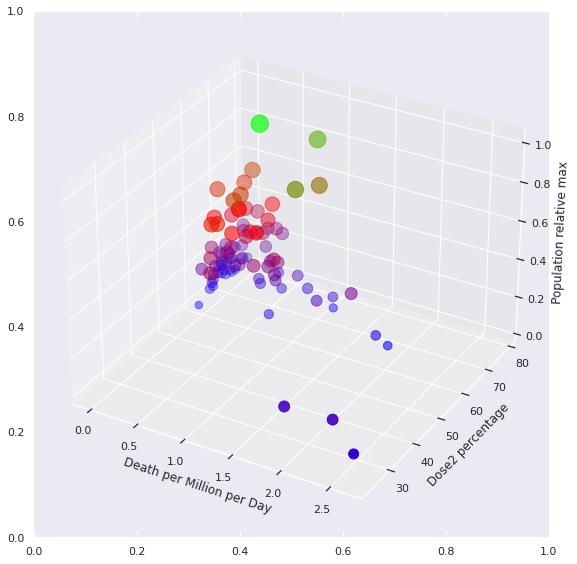

In [72]:
## Older version

vdm=vacDepMerged
fig, ax1 = PLT.subplots(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

x=vdm.loc[:,"incid_dc_perM"]
y=vdm.loc[:,"n_cum_dose2_perC"]
z=popRel

ax.scatter(x, y, z, c = colors, 
              s = 2*size, marker="o")

ax.set_xlabel('Death per Million per Day')
ax.set_ylabel('Dose2 percentage')
ax.set_zlabel('Population relative max')
ImgMgr.save_fig("FIG315")

## Scikit used for classification

First we adapt the data by entering the relative population  size of the departement in column `PopRel`.

In [73]:
selcols=[vacDepMerged.columns[3]]
selcols.extend(vacDepMerged.columns[14:])
vdm=vacDepMerged.loc[:,selcols].copy()
vdm.loc[:,'PopRel'] = vdm.loc[:,'Population totale'] / max(vdm.loc[:,'Population totale'])

This means that the area of the dots is (roughly) proportional to the population.

figObj.kwargs['data'].shape = (91, 14)
figArgDict keys=<built-in method keys of dict object at 0x7fb2dd9f8cc0>
In <class 'lib.figureHelpers.FigAdapter_KMeans'>.__call__: fitted j  KMeans classifier
type colors:<class 'numpy.ndarray'>


Saving figure FIG316


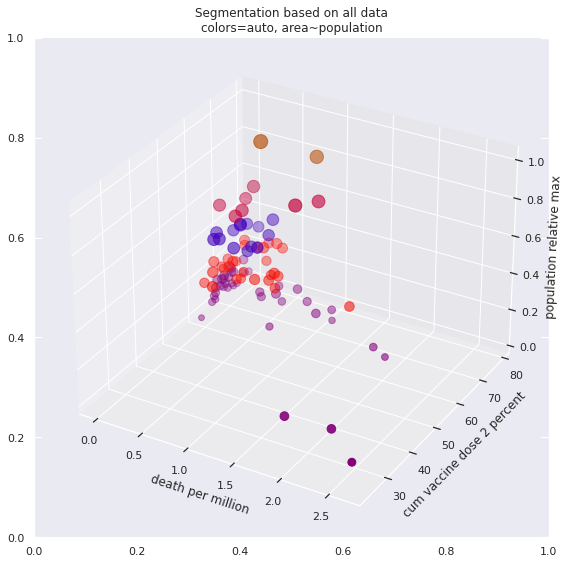

In [74]:
sizes = 16*(150*vdm.loc[:,'PopRel']).map(lambda x: max(0.1,sqrt(x)))

nbClusters=5
figAdaptKM = FHelp.FigAdapter_KMeans(fitData = vdm, nbClusters = nbClusters)
figSc3D = FHelp.FigFrom3DScatterPlot( adapter = figAdaptKM, data = vdm, figsize=(8,8),
                                    sizes = sizes)

            # this fits the data and prepares the figure
figSc3D( xcol="incid_dc_perM",
         ycol="n_cum_dose2_perC", 
         zcol='PopRel',
         xlabel="death per million",
         ylabel="cum vaccine dose 2 percent",
         zlabel="population relative max",
         title="Segmentation based on all data\ncolors=auto, area~population")

ImgMgr.save_fig("FIG316")

## Try to obtain improved classification
Here, we try to improve classification, in particular by preprocessing, normalizing data and the like.
After all we have all Scikit abilities at hand:
- documented at https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing
  - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
- The user guide is available at https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler


Some information may be gleaned from 
- https://stackoverflow.com/questions/20027645/does-kmeans-normalize-features-automatically-in-sklearn
  - a practical example is shown at https://stackoverflow.com/questions/57507584/feature-scaling-for-kmeans-algorithm


### Use data standardisation

figObj.kwargs['data'].shape = (91, 14)
figArgDict keys=<built-in method keys of dict object at 0x7fb2dd9fe4c0>
In <class 'lib.figureHelpers.FigAdapter_KMeans'>.dfNormalizereturning
                 0             1             2             3             4   \
count  9.100000e+01  9.100000e+01  9.100000e+01  9.100000e+01  9.100000e+01   
mean   1.116323e-16 -1.685160e-17  1.927640e-16 -1.098023e-16 -2.196046e-17   
std    1.005540e+00  1.005540e+00  1.005540e+00  1.005540e+00  1.005540e+00   
min   -1.197607e+00 -1.204919e+00 -1.367885e+00 -9.040913e-01 -1.369885e+00   
25%   -7.428442e-01 -7.367104e-01 -7.166684e-01 -6.462326e-01 -7.006990e-01   
50%   -2.575264e-01 -2.340346e-01 -2.474565e-01 -2.806121e-01 -2.351838e-01   
75%    3.745787e-01  4.986794e-01  4.324573e-01  2.062404e-01  3.677199e-01   
max    3.711375e+00  3.547126e+00  3.882182e+00  5.519283e+00  3.905012e+00   

                 5             6             7             8             9   \
count  9.100000e+01  9.10000

Saving figure FIG317


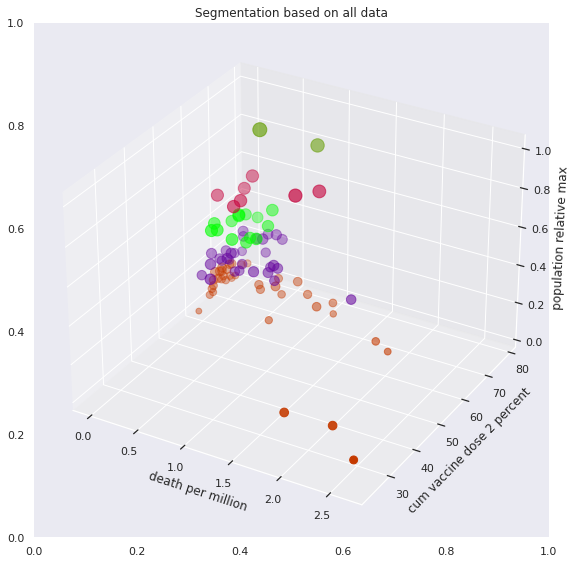

In [75]:
sizes = 16*(150*vdm.loc[:,'PopRel']).map(lambda x: max(0.01,sqrt(x)))

nbClusters=5
figAdaptKM = FHelp.FigAdapter_KMeans(fitData = vdm.iloc[:,1:], nbClusters = nbClusters, 
                                     scaler="standard")

colormap = CM.get_cmap('brg', 32)
# lambda is used to defer evaluation of the labels
lambdaColors = lambda x : colormap((1+ figAdaptKM.k_means.labels_)/nbClusters)
lambdaSize =  sizes

figSc3D = FHelp.FigFrom3DScatterPlot( adapter = figAdaptKM, data = vdm, 
                                      figsize=(8,8))

            # this fits the data and prepares the figure
figSc3D( xcol="incid_dc_perM",
         ycol="n_cum_dose2_perC", 
         zcol='PopRel',
         colors = lambdaColors,
         sizes =  lambdaSize,
         xlabel="death per million",
         ylabel="cum vaccine dose 2 percent",
         zlabel="population relative max",
         title="Segmentation based on all data")

ImgMgr.save_fig("FIG317")


### Do not fit based on population data

figObj.kwargs['data'].shape = (91, 14)
figArgDict keys=<built-in method keys of dict object at 0x7fb2dd946f40>
In <class 'lib.figureHelpers.FigAdapter_KMeans'>.dfNormalizereturning
                 0             1             2             3             4   \
count  9.100000e+01  9.100000e+01  9.100000e+01  9.100000e+01  9.100000e+01   
mean   1.116323e-16 -1.685160e-17  1.927640e-16 -1.098023e-16 -2.196046e-17   
std    1.005540e+00  1.005540e+00  1.005540e+00  1.005540e+00  1.005540e+00   
min   -1.197607e+00 -1.204919e+00 -1.367885e+00 -9.040913e-01 -1.369885e+00   
25%   -7.428442e-01 -7.367104e-01 -7.166684e-01 -6.462326e-01 -7.006990e-01   
50%   -2.575264e-01 -2.340346e-01 -2.474565e-01 -2.806121e-01 -2.351838e-01   
75%    3.745787e-01  4.986794e-01  4.324573e-01  2.062404e-01  3.677199e-01   
max    3.711375e+00  3.547126e+00  3.882182e+00  5.519283e+00  3.905012e+00   

                 5             6             7             8             9   \
count  9.100000e+01  9.10000

Saving figure FIG318


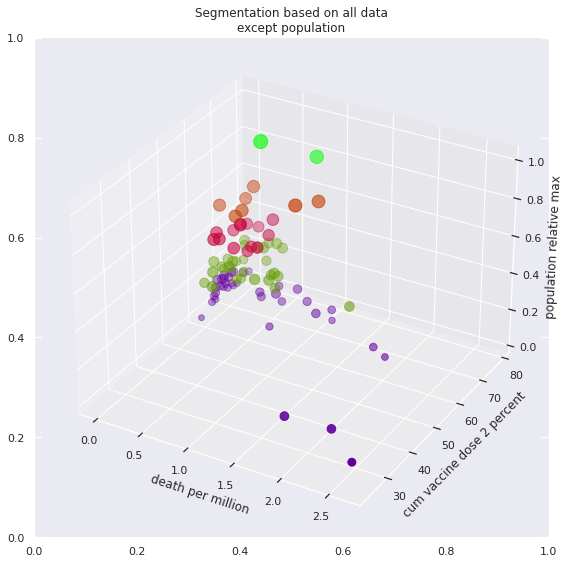

In [76]:
sizes = 16*(150*vdm.loc[:,'PopRel']).map(lambda x: max(0.01,sqrt(x)))

nbClusters=5
figAdaptKM = FHelp.FigAdapter_KMeans(fitData = vdm.iloc[:,1:-1], 
                                     nbClusters = nbClusters, 
                                     scaler="standard")

colormap = CM.get_cmap('brg', 32)
# lambda is used to defer evaluation of the labels
lambdaColors = lambda x : colormap((1+ figAdaptKM.k_means.labels_)/nbClusters)
lambdaSize =  sizes

figSc3D = FHelp.FigFrom3DScatterPlot( adapter = figAdaptKM, data = vdm, 
                                      figsize=(8,8))

            # this fits the data and prepares the figure
figSc3D( xcol="incid_dc_perM",
         ycol="n_cum_dose2_perC", 
         zcol='PopRel',
         colors = lambdaColors,
         sizes =  lambdaSize,
         xlabel="death per million",
         ylabel="cum vaccine dose 2 percent",
         zlabel="population relative max",
         title="Segmentation based on all data\nexcept population")

ImgMgr.save_fig("FIG318")


figObj.kwargs['data'].shape = (91, 14)
figArgDict keys=<built-in method keys of dict object at 0x7fb2dd8b81c0>
In <class 'lib.figureHelpers.FigAdapter_KMeans'>.dfNormalizereturning
                 0             1             2             3             4   \
count  9.100000e+01  9.100000e+01  9.100000e+01  9.100000e+01  9.100000e+01   
mean   1.116323e-16 -1.685160e-17  1.927640e-16 -1.098023e-16 -2.196046e-17   
std    1.005540e+00  1.005540e+00  1.005540e+00  1.005540e+00  1.005540e+00   
min   -1.197607e+00 -1.204919e+00 -1.367885e+00 -9.040913e-01 -1.369885e+00   
25%   -7.428442e-01 -7.367104e-01 -7.166684e-01 -6.462326e-01 -7.006990e-01   
50%   -2.575264e-01 -2.340346e-01 -2.474565e-01 -2.806121e-01 -2.351838e-01   
75%    3.745787e-01  4.986794e-01  4.324573e-01  2.062404e-01  3.677199e-01   
max    3.711375e+00  3.547126e+00  3.882182e+00  5.519283e+00  3.905012e+00   

                 5             6             7             8             9   \
count  9.100000e+01  9.10000

Saving figure FIG319


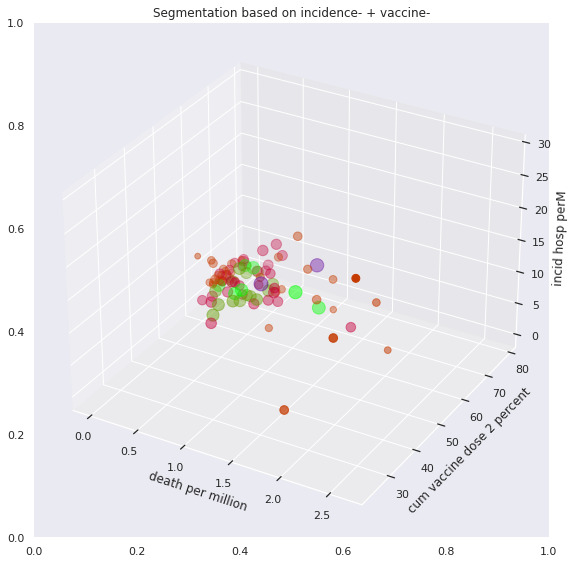

In [77]:
fitCols=list(range(1,4))
fitCols.extend(range(5,7))

sizes = 16*(150*vdm.loc[:,'PopRel']).map(lambda x: max(0.01,sqrt(x)))

nbClusters=5
figAdaptKM = FHelp.FigAdapter_KMeans(fitData = vdm.iloc[:,fitCols], 
                                     nbClusters = nbClusters, 
                                     scaler="standard")

colormap = CM.get_cmap('brg', 32)
# lambda is used to defer evaluation of the labels
lambdaColors = lambda x : colormap((1+ figAdaptKM.k_means.labels_)/nbClusters)
lambdaSize =  sizes

figSc3D = FHelp.FigFrom3DScatterPlot( adapter = figAdaptKM, data = vdm, 
                                      figsize=(8,8))

            # this fits the data and prepares the figure
figSc3D( xcol="incid_dc_perM",
         ycol="n_cum_dose2_perC", 
         zcol='incid_hosp_perM',
         colors = lambdaColors,
         sizes =  lambdaSize,
         xlabel="death per million",
         ylabel="cum vaccine dose 2 percent",
         zlabel="incid hosp perM",
         title="Segmentation based on incidence- + vaccine-")

ImgMgr.save_fig("FIG319")


In [78]:
vdm.iloc[:,fitCols]

,n_cum_dose2,n_cum_dose3,n_cum_dose4,incid_hosp_perM,incid_rea_perM
0,209636.0,12363.714286,15.571429,3.153400,0.450486
1,245749.0,15554.714286,7.857143,4.522060,0.000000
2,197422.0,13260.142857,1.000000,3.454375,0.493482
3,1219920.0,70812.714286,67.714286,7.252679,1.673695
4,526852.0,29897.571429,29.285714,1.815099,0.605033
...,...,...,...,...,...
86,758333.0,32006.571429,22.285714,3.458279,1.268036
87,111480.0,3908.428571,3.714286,3.966721,2.163666
88,110123.0,3742.285714,2.000000,16.641597,6.051490
89,63569.0,1325.428571,0.000000,28.979887,7.376698
